In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pydot
import pydotplus as pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook',palette='deep')
np.random.seed(seed=2)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading BokehJS ...

In [3]:
dataset = pd.read_csv("data.csv")

In [4]:
dataset.shape


(14999, 10)

In [5]:
dataset.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
dataset.isnull().any()


satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

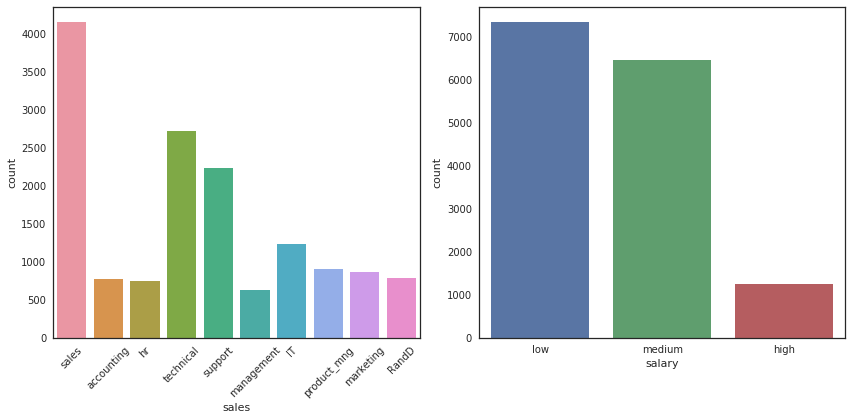

In [7]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
g = sns.countplot(dataset["sales"], ax = axs[0])
plt.setp(g.get_xticklabels(), rotation = 45)
g = sns.countplot(dataset["salary"], ax = axs[1])
plt.tight_layout()
plt.show();



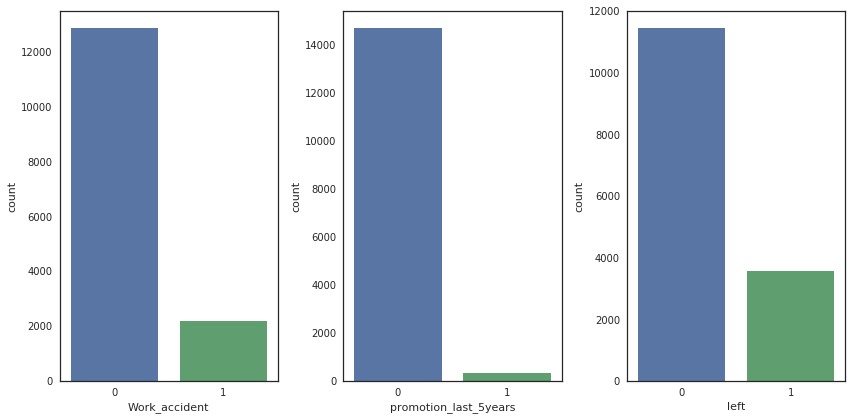

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
sns.countplot(dataset["Work_accident"], ax=axs[0])
sns.countplot(dataset["promotion_last_5years"], ax=axs[1])
sns.countplot(dataset["left"], ax=axs[2])
plt.tight_layout()
plt.show();

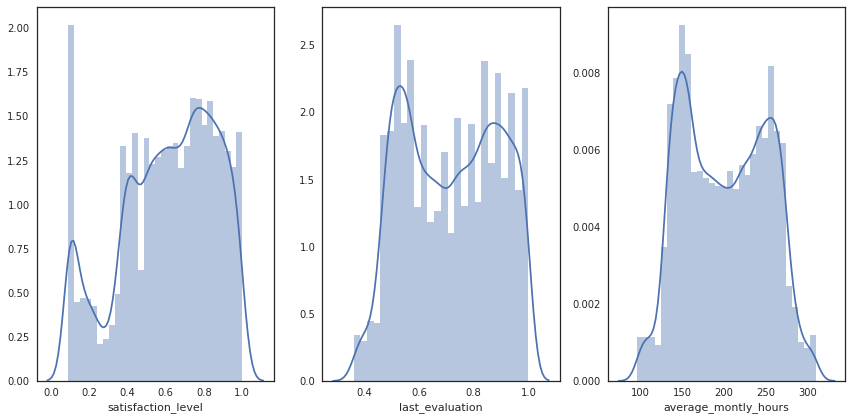

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(12,6))
sns.distplot(dataset["satisfaction_level"], ax = axs[0])
sns.distplot(dataset["last_evaluation"], ax = axs[1])
sns.distplot(dataset["average_montly_hours"], ax=axs[2])
plt.tight_layout()
plt.show();

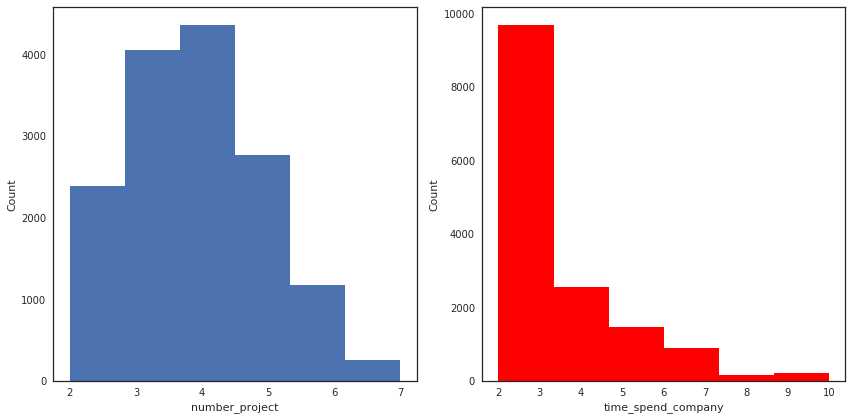

In [10]:
fig,axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].hist(dataset["number_project"], bins=6)
axs[0].set_xlabel("number_project")
axs[0].set_ylabel("Count")
axs[1].hist(dataset["time_spend_company"], bins=6, color="r")
axs[1].set_xlabel("time_spend_company")
axs[1].set_ylabel("Count")
plt.tight_layout()
plt.show();

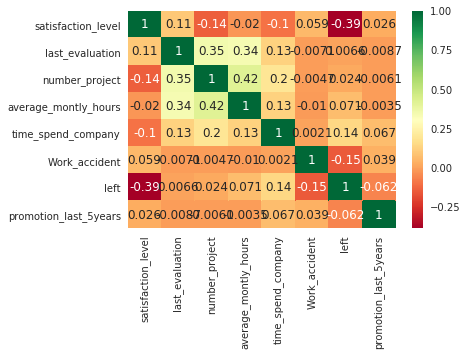

In [11]:
g = sns.heatmap(dataset.corr(), annot=True, cmap="RdYlGn")

In [12]:
dataset = dataset.drop(labels=["sales"],axis=1)


In [13]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,1,0,low
1,0.80,0.86,5,262,6,0,1,0,medium
2,0.11,0.88,7,272,4,0,1,0,medium
3,0.72,0.87,5,223,5,0,1,0,low
4,0.37,0.52,2,159,3,0,1,0,low


In [14]:
dataset["salary"] = dataset["salary"].astype("category", ordered=True,
                     categories=['low','medium','high']).cat.codes


In [15]:
N = StandardScaler()
N.fit(dataset)
dataset_norm = N.transform(dataset)

In [16]:
index = np.random.randint(0, dataset_norm.shape[0], size=10000)

In [17]:
pca = PCA(n_components=2)
pca_representation = pca.fit_transform(dataset_norm[index])

In [18]:
iso = Isomap(n_components=2, n_neighbors=40)
iso_representation = iso.fit_transform(dataset_norm[index])

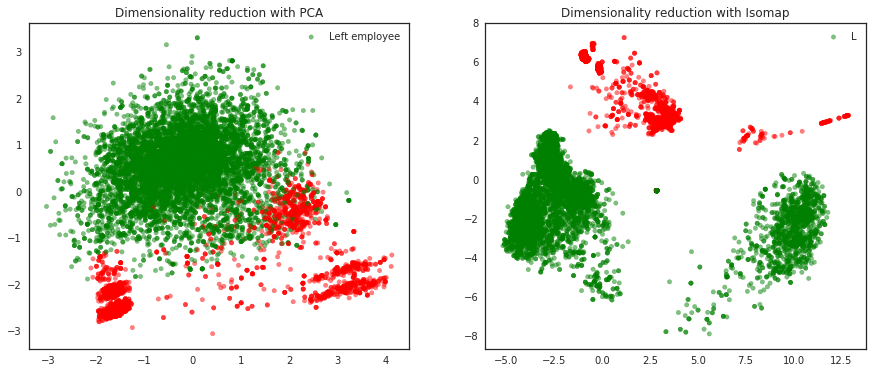

In [19]:
left_colors = dataset["left"].map(lambda s : "g" if s==0 else "r")
fig,axes = plt.subplots(1,2,figsize=(15,6))

axes[0].scatter(pca_representation[:,0],pca_representation[:,1],
c = left_colors[index],alpha=0.5, s = 20)
axes[0].set_title("Dimensionality reduction with PCA")
axes[0].legend(["Left employee"])

axes[1].scatter(iso_representation[:,0], iso_representation[:,1],
               c = left_colors[index],alpha=0.5, s = 20)
axes[1].set_title("Dimensionality reduction with Isomap")
axes[1].legend("Left employee");


In [20]:
source_dataset = ColumnDataSource(
        data = dict(
            x = iso_representation[:2000,0],
            y = iso_representation[:2000,1],
            desc = dataset.loc[index,"left"],
            colors = ["#%02x%02x%02x" % (int(c*255), int((1-c)*255), 0) 
            for c in dataset.loc[index,"left"]],
            satisfaction_level = dataset.loc[index,'satisfaction_level'],
            last_evaluation = dataset.loc[index,'last_evaluation'],
            number_project = dataset.loc[index,'number_project'],
            time_spend_company = dataset.loc[index,'time_spend_company'],
            average_montly_hours = dataset.loc[index,'average_montly_hours']))
        
hover = HoverTool(tooltips=[("Left", "@desc"), 
                       ("Satisf. level", "@satisfaction_level"),
                       ("#projects", "@number_project"), 
                       ("Last eval.", "@last_evaluation"),
                       ("Time in Company", "@time_spend_company"),
                       ("Montly hrs", "@average_montly_hours")])

tools_isomap = [hover, "box_zoom",'pan', 'wheel_zoom', 'reset']

plot_isomap = figure(plot_width= 800, plot_height=600, tools=tools_isomap, 
                     title='Isomap projection of employee data')
plot_isomap.scatter('x', 'y', size=7, fill_color = "colors", line_color = None,
                    fill_alpha = 0.6, radius=0.1, alpha=0.5, line_width=0,
                    source=source_dataset)
show(plot_isomap)

In [21]:
data_stay = dataset[dataset["left"]==0]
data_left = dataset[dataset["left"]==1]

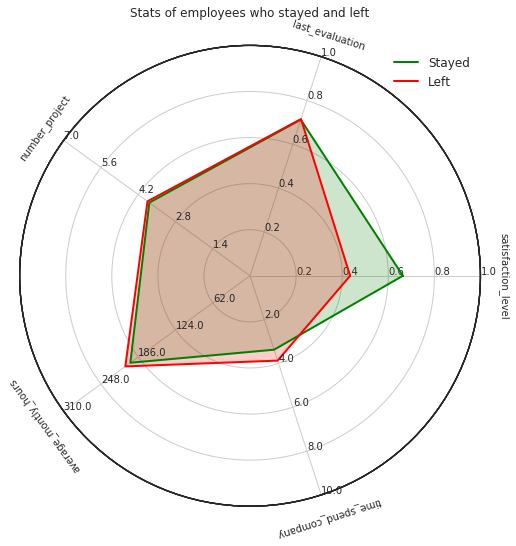

In [22]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.8,0.8],polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)


attributes = ['satisfaction_level','last_evaluation','number_project',
              'average_montly_hours','time_spend_company']



data_stay_mean = data_stay[attributes].mean().values.reshape(1,-1)
data_left_mean = data_left[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_mean),axis = 0)

ranges = [[1e-2, dataset[attr].max()] for attr in attributes]
colors = ["green","red"]
left_types = ["Stayed","Left"]


fig = plt.figure(figsize=(8, 8))
radar = RadarChart(fig, attributes, ranges)

for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type, linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = color)
    radar.legend(loc = 1, fontsize = 'medium')

plt.title('Stats of employees who stayed and left')
plt.show();

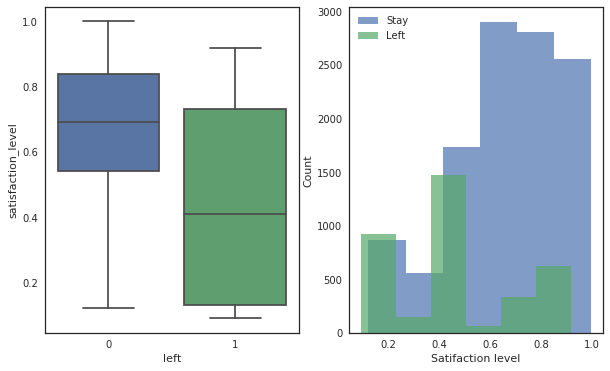

In [23]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="satisfaction_level",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["satisfaction_level"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["satisfaction_level"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Satifaction level")
axs[1].set_ylabel("Count")
axs[1].legend();
plt.tight_layout();
plt.gcf().clear();

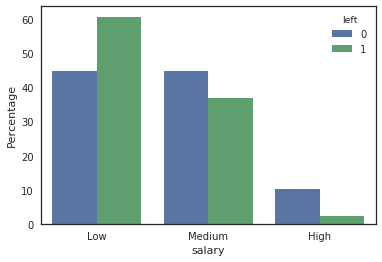

In [24]:
salary_counts = (dataset.groupby(['left'])['salary']
                    .value_counts(normalize=True)
                    .rename('percentage')
                    .mul(100)
                    .reset_index())
p = sns.barplot(x="salary",y="percentage",hue="left",data=salary_counts)
p.set_ylabel("Percentage")
p = p.set_xticklabels(["Low","Medium","High"])

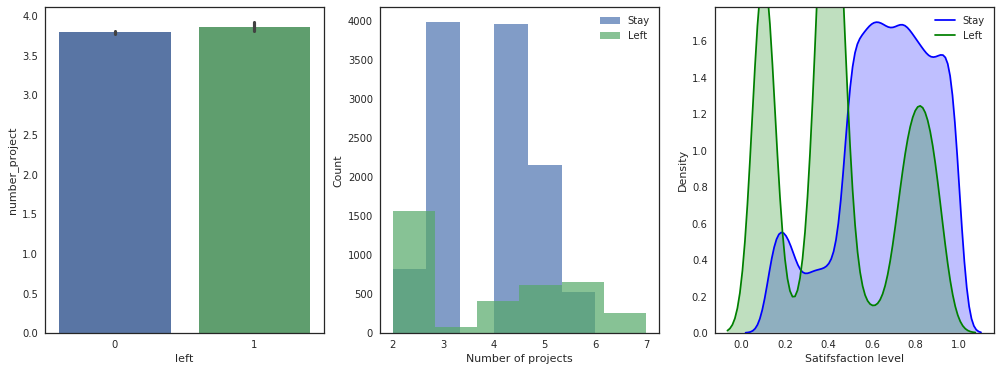

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17,6))
sns.factorplot(y="number_project", x="left", data=dataset, kind="bar",ax=axs[0])
axs[1].hist(data_stay["number_project"], bins=6, label="Stay",alpha=0.7)
axs[1].hist(data_left["number_project"], bins=6, label="Left",alpha=0.7)
axs[1].set_xlabel("Number of projects")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["satisfaction_level"],color='b',shade=True, ax=axs[2])
ax = sns.kdeplot(data=data_left["satisfaction_level"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay", "Left"])
ax.set_xlabel('Satifsfaction level')
ax.set_ylabel('Density')

plt.tight_layout();
plt.gcf().clear()

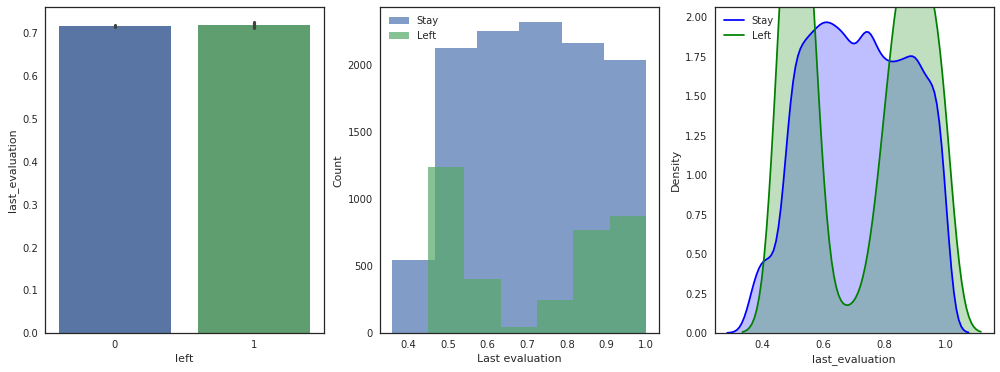

In [26]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(17,6))

sns.factorplot(y="last_evaluation",x="left",data=dataset,kind="bar", ax=axs[0])

axs[1].hist(data_stay["last_evaluation"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["last_evaluation"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Last evaluation")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["last_evaluation"],color='b',shade=True, ax=axs[2])
ax = sns.kdeplot(data=data_left["last_evaluation"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay","Left"])
ax.set_xlabel('last_evaluation')
ax.set_ylabel('Density')

plt.tight_layout()
plt.gcf().clear()

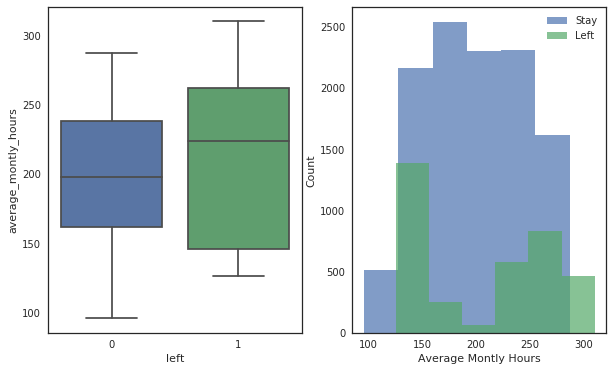

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="average_montly_hours",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["average_montly_hours"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["average_montly_hours"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Average Montly Hours")
axs[1].set_ylabel("Count")
axs[1].legend()
plt.tight_layout()
plt.gcf().clear()

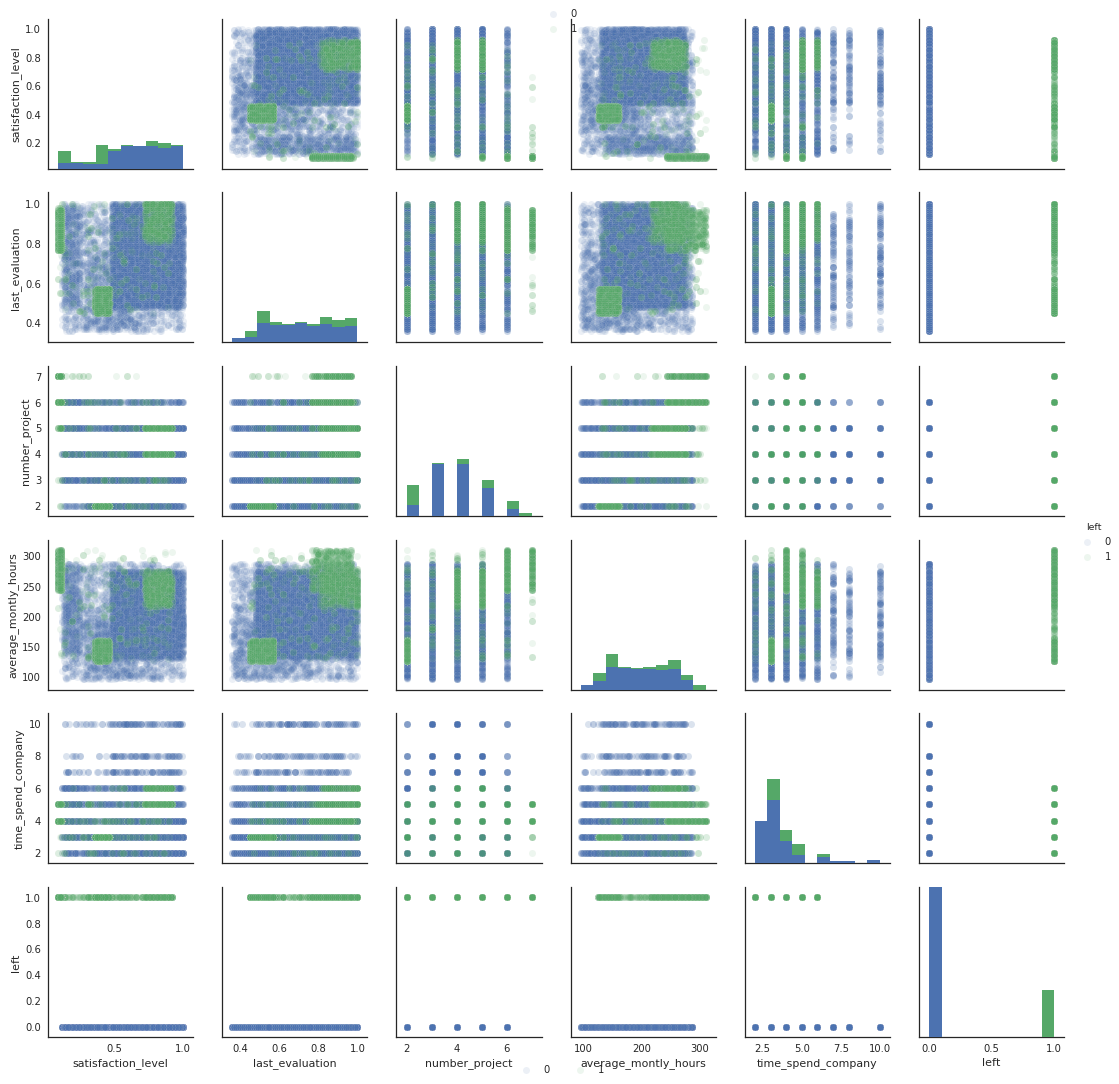

In [28]:
g = sns.pairplot(dataset.drop(labels=['promotion_last_5years','Work_accident','salary'],axis=1),hue="left",plot_kws=dict(alpha=0.1))
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)

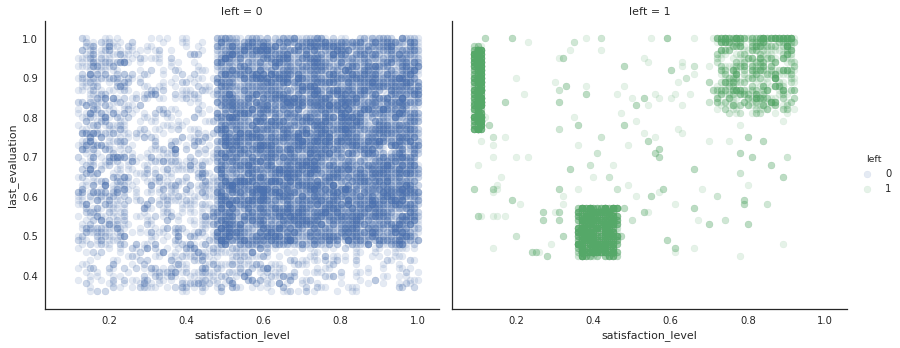

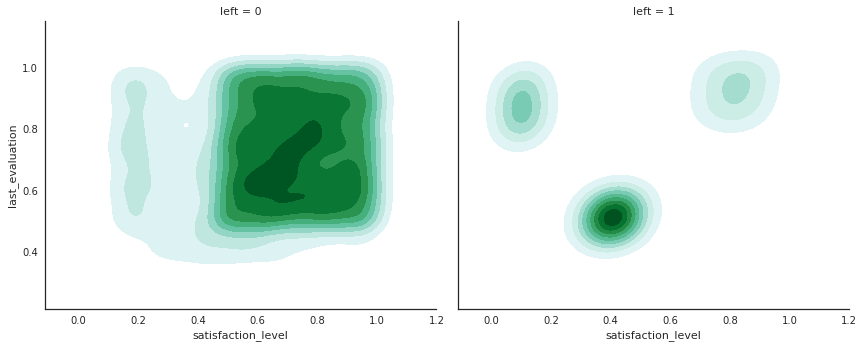

In [29]:
#Deeper in analysis
g = sns.FacetGrid(dataset, col="left",hue="left", size=5, aspect=1.2)
g.map(plt.scatter, "satisfaction_level", "last_evaluation", alpha=0.15)
g.add_legend()

g = sns.FacetGrid(dataset, col="left",size=5,aspect=1.2)
g.map(sns.kdeplot, "satisfaction_level","last_evaluation", shade=True, shade_lowest=False)
g.add_legend()

In [30]:
#Lets compare inside the 3 identified groups
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(data_left[["satisfaction_level","last_evaluation"]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

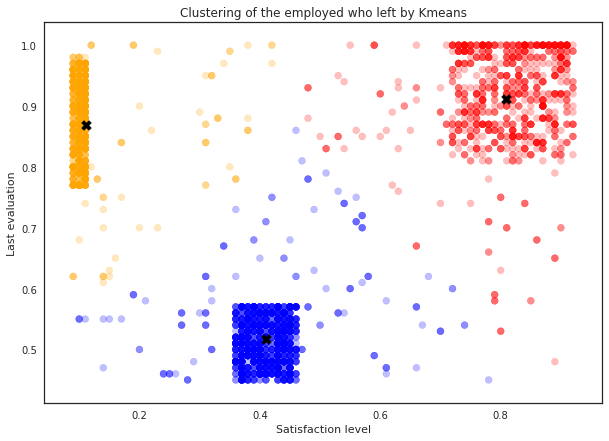

In [31]:
kmeans_colors = ['red' if c == 0 else 'orange' if c == 2 else 'blue' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 7))
plt.scatter(x="satisfaction_level",y="last_evaluation", data=data_left,
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction level")
plt.ylabel("Last evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clustering of the employed who left by Kmeans")

plt.show()

In [32]:
data_left_SuccessHappy = data_left[kmeans.labels_ == 0]
data_left_UnsuccessUnhappy = data_left[kmeans.labels_ == 1]
data_left_SuccessUnhappy = data_left[kmeans.labels_ == 2]


In [33]:
data_left_SuccessUnhappy.shape


(944, 9)

In [34]:
data_left_SuccessHappy.shape

(977, 9)

In [35]:
data_left_UnsuccessUnhappy.shape

(1650, 9)

In [36]:
data_left_SuccessUnhappy_mean = data_left_SuccessUnhappy[attributes].mean().values.reshape(1,-1)
data_left_SuccessHappy_mean = data_left_SuccessHappy[attributes].mean().values.reshape(1,-1)
data_left_UnsuccessUnhappy_mean = data_left_UnsuccessUnhappy[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_SuccessUnhappy_mean, 
                        data_left_SuccessHappy_mean,data_left_UnsuccessUnhappy_mean),axis = 0)

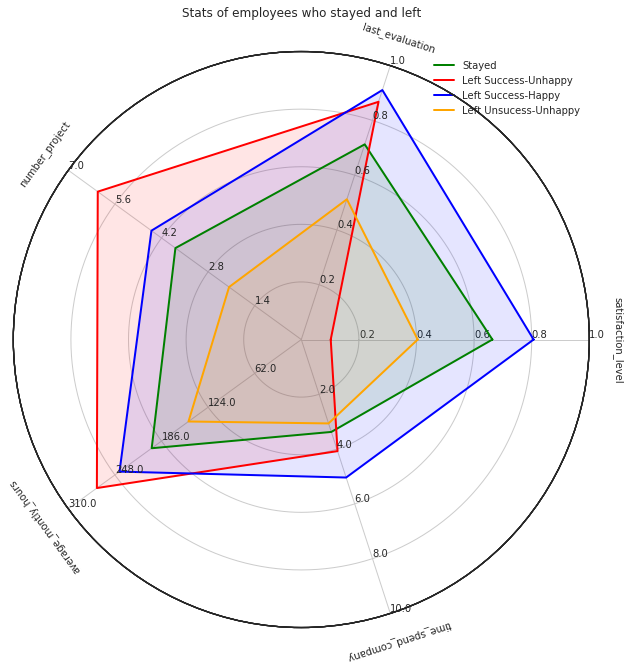

In [37]:
colors = ["green","red","blue","orange"]
left_types = ["Stayed","Left Success-Unhappy", "Left Success-Happy", "Left Unsucess-Unhappy"]

fig = plt.figure(figsize=(10, 10))
radar = RadarChart(fig, attributes, ranges)
for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type,linewidth=2.0)
    radar.fill(data, alpha = 0.1, color = color)
    radar.legend(loc = 1, fontsize = 'small')
plt.title('Stats of employees who stayed and left')
plt.show() 

In [38]:
## Prediction of the target variable (stay/left)

X_train = dataset.drop(labels = "left", axis=1)
Y_train = dataset["left"]
train_features = X_train.columns

In [39]:
kfold = StratifiedKFold(Y_train, n_folds=10, random_state=2)

In [40]:
DTC = DecisionTreeClassifier(max_depth=3)
cv_results = cross_val_score(DTC,X_train, Y_train, cv=kfold,scoring="accuracy")
cv_results.mean()

0.95239079072183286

In [41]:
DTC.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
### NOT WORKING ON KAGGLE SERVERS (no module pydot nor pydotplus)####
#dot_data = StringIO()

#tree.export_graphviz(DTC, out_file=dot_data,feature_names=train_features)

#graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
#graph.set_lwidth(400)
#graph.set_lheight(300)

#Image(graph.create_png())



In [43]:
RFC = RandomForestClassifier()
cv_results = cross_val_score(RFC,X_train, Y_train, cv=kfold,scoring="accuracy")
cv_results.mean()

0.99140008877040986

In [44]:
RFC.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

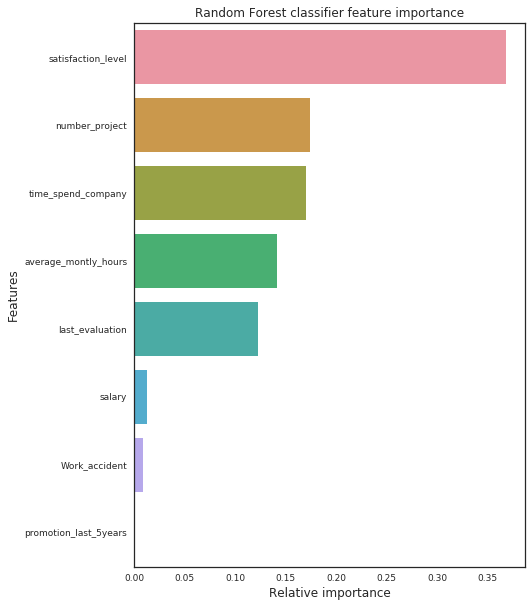

In [45]:
indices = np.argsort(RFC.feature_importances_)[::-1][:40]

fig = plt.figure(figsize=(7, 10))
g = sns.barplot(y=train_features[indices][:40],x = RFC.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random Forest classifier feature importance")

plt.show()
plt.gcf().clear()